# Quantum Watermarking - greyscale

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from qiskit import *

In [2]:
C_Image = np.zeros([2,2,3]) # (x,y,RGB)

C_Image[0,0,:] = (0,   128, 128)
C_Image[0,1,:] = (128, 0,   128)
C_Image[1,0,:] = (128, 128, 0)
C_Image[1,1,:] = (128, 128, 128)

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

C_Image = rgb2gray(C_Image)
C_Image

array([[ 89.728 ,  52.8512],
       [113.3952, 127.9872]])

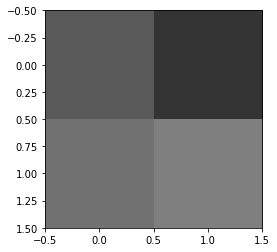

In [4]:
plt.imshow(C_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [5]:
W_Image = np.zeros([2,2,3]) # (x,y,RGB)

W_Image[0,0,:] = (34,   65, 232)
W_Image[0,1,:] = (255, 255,   255)
W_Image[1,0,:] = (228, 128, 54)
W_Image[1,1,:] = (54, 54, 54)

W_Image = rgb2gray(W_Image)
W_Image

array([[ 74.7656, 254.9745],
       [149.4412,  53.9946]])

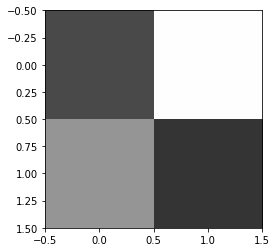

In [6]:
plt.imshow(W_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [7]:
def get_Coeff(Image, watermark=None):
    """ Function that takes in an RGB image matrix of any size and shape and returns qubit coefficients"""
    
    ## build in check sizes Image and watermark are the same
    Flatten_Image = np.reshape(Image, np.shape(Image)[0]*np.shape(Image)[1])
    Theta = Flatten_Image*np.pi/256
    
    if watermark is None:
        Phi = np.zeros(len(Theta))
    else:  
        Flatten_watermark = np.reshape(watermark, np.shape(watermark)[0]*np.shape(watermark)[1])
        Phi = Flatten_watermark*2*np.pi/256

    N = np.ceil(np.log2(np.shape(Image)[0]*np.shape(Image)[1]))/2
    return Phi,Theta,1/(2**N)*np.ndarray.flatten(np.transpose(np.stack((np.cos(Theta/2),np.exp(1j*Phi)*np.sin(Theta/2)))))

In [8]:
State_vector = get_Coeff(C_Image, W_Image)[2]
State_vector

array([ 0.42611477+0.j        , -0.06831626+0.25250563j,
        0.47393845+0.j        ,  0.1592679 -0.00400955j,
        0.38377563+0.j        , -0.27713054-0.16098115j,
        0.35358116+0.j        ,  0.08594517+0.34291951j])

In [9]:
def initialise_state(desired_initial_state):
    n = int(round(np.log2(desired_initial_state.size)))
    
    # if 2**n != desired_initial_state.size:
        # don't run
    
    qc_init = QuantumCircuit(n)

    qc_init.initialize(desired_initial_state, range(n))
    return qc_init

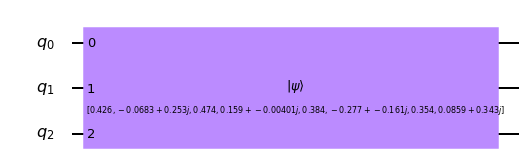

In [10]:
qc_init = initialise_state(State_vector)
qc_init.draw('mpl')

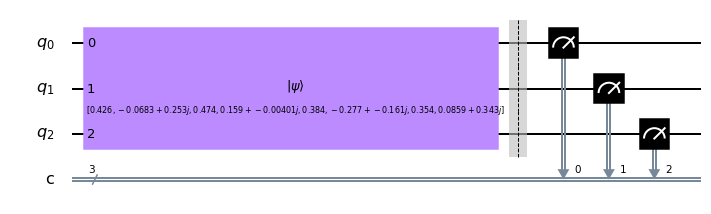

In [11]:
n = int(round(np.log2(State_vector.size)))
shots0 = 100000

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
qc.draw('mpl')

In [12]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'000': 18198, '001': 6795, '010': 22459, '011': 2529, '100': 14864, '101': 10480, '110': 12317, '111': 12358}


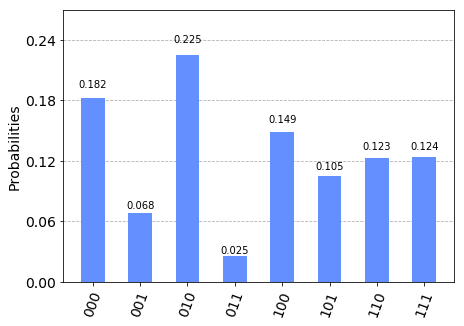

In [13]:
counts = result_sim.get_counts(qc)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [14]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.18198 0.06795 0.22459 0.02529 0.14864 0.1048  0.12317 0.12358]


In [15]:
p0 = probability_vector[0::2]
p1 = probability_vector[1::2]

In [16]:
def get_RGB(P0):
    """ Function that takes the probablity distribution for the colour qubit 0 """
    Theta = 2*np.arccos(np.sqrt(len(P0)*P0))

    return Theta, np.reshape(Theta/np.pi*256,[np.int(np.sqrt(len(Theta))),np.int(np.sqrt(len(Theta)))])

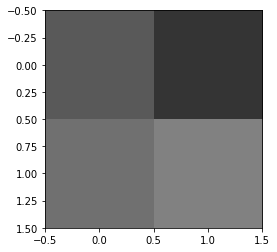

In [17]:
P_Image = get_RGB(p0)[1]
plt.imshow(P_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

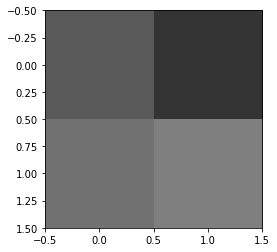

In [18]:
plt.imshow(C_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

### Extracting the watermark

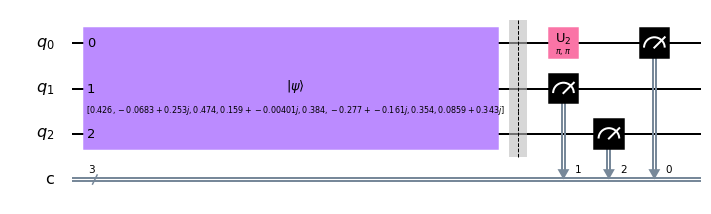

In [19]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas_phi = QuantumCircuit(n, n)
meas_phi.barrier(range(n))
meas_phi.u2(np.pi, np.pi, 0)
# map the quantum measurement to the classical bits
meas_phi.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc_phi = qc_init + meas_phi

#drawing the circuit
qc_phi.draw('mpl')

In [20]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc_phi, backend_sim, shots=shots0)#, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'000': 96118, '001': 154213, '010': 201111, '011': 49031, '100': 18622, '101': 231028, '110': 154998, '111': 94879}


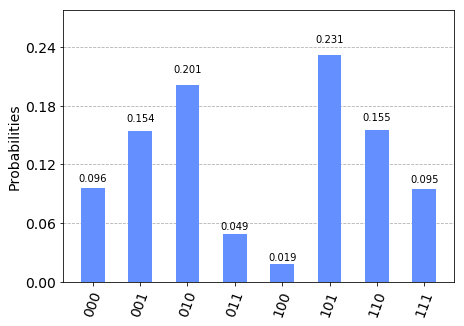

In [21]:
counts = result_sim.get_counts(qc_phi)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [22]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.096118 0.154213 0.201111 0.049031 0.018622 0.231028 0.154998 0.094879]


In [23]:
P0_1 = probability_vector[0::2] 
P1_1= probability_vector[1::2]

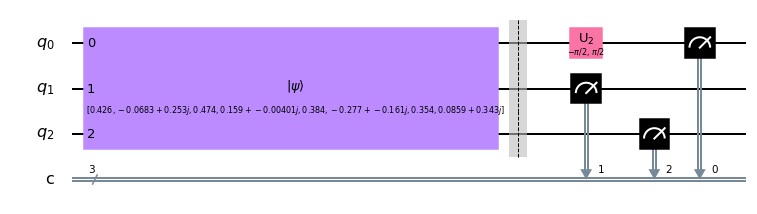

In [24]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas_phi2 = QuantumCircuit(n, n)
meas_phi2.barrier(range(n))
meas_phi2.u2(-np.pi/2, np.pi/2, 0)
# map the quantum measurement to the classical bits
meas_phi2.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc_phi2 = qc_init + meas_phi2

#drawing the circuit
qc_phi2.draw('mpl')

In [25]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc_phi2, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'000': 232311, '001': 17593, '010': 123045, '011': 126696, '100': 63297, '101': 187544, '110': 245851, '111': 3663}


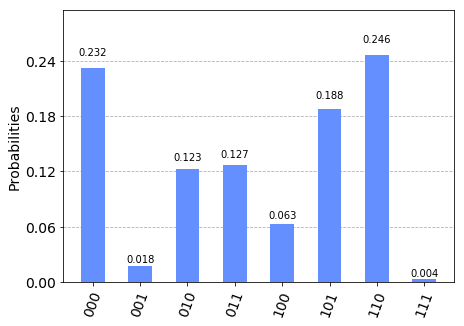

In [26]:
counts = result_sim.get_counts(qc_phi2)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [27]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.232311 0.017593 0.123045 0.126696 0.063297 0.187544 0.245851 0.003663]


In [28]:
P0_2 = probability_vector[0::2] 
P1_2 = probability_vector[1::2]

In [29]:
x = P0_1 - P1_1
y = P0_2 - P1_2

In [30]:
def get_watermark(x,y):
    """ Returns RGB watermark matrix image from the probabilities of the colour qubit being 0 (P0) or 1 P(1)
        and the carrier image is encoded by the angles Theta.
    """
    Phi = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] > 0 and y[i] > 0:
            Phi[i] = np.arctan(y[i]/x[i])
        elif x[i] > 0 and y[i] < 0:
            Phi[i] = 2*np.pi + np.arctan(y[i]/x[i])
        elif x[i] < 0:
            Phi[i] = np.pi + np.arctan(y[i]/x[i])
            

    return np.reshape(Phi/2/np.pi*256,[np.int(np.sqrt(len(Phi))),np.int(np.sqrt(len(Phi)))])

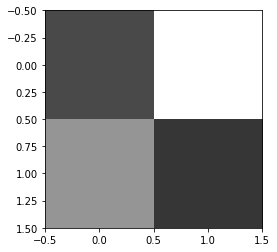

In [31]:
RW_Image = get_watermark(x,y)
plt.imshow(RW_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

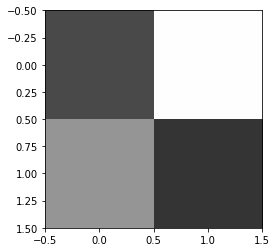

In [32]:
plt.imshow(W_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

### Bigger Image

In [63]:
img_file = os.path.expanduser("IBM-logo.png")

In [64]:
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
res = cv2.resize(img, dsize=(8, 8), interpolation=cv2.INTER_CUBIC)

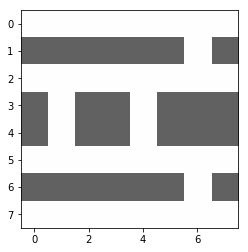

In [65]:
W_Image = rgb2gray(res)
plt.imshow(W_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [66]:
img_file2 = os.path.expanduser("cat.png")

In [69]:
img2 = cv2.imread(img_file2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
res2 = cv2.resize(img2, dsize=(8, 8), interpolation=cv2.INTER_CUBIC)

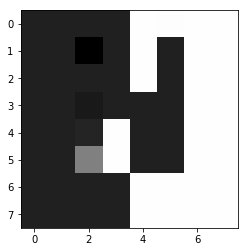

In [70]:
C_Image = rgb2gray(res2)
plt.imshow(C_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [71]:
State_vector = get_Coeff(C_Image, W_Image)[2]
State_vector

array([ 0.12255208+0.j        ,  0.02460902-0.00061953j,
        0.12255208+0.j        ,  0.02460902-0.00061953j,
        0.12255208+0.j        ,  0.02460902-0.00061953j,
        0.12255208+0.j        ,  0.02460902-0.00061953j,
        0.00078654+0.j        ,  0.12495793-0.0031458j ,
        0.0020036 +0.j        ,  0.12494435-0.00314546j,
        0.00078654+0.j        ,  0.12495793-0.0031458j ,
        0.00078654+0.j        ,  0.12495793-0.0031458j ,
        0.12255208+0.j        , -0.01783361+0.01696908j,
        0.12255208+0.j        , -0.01783361+0.01696908j,
        0.125     +0.j        , -0.        +0.j        ,
        0.12255208+0.j        , -0.01783361+0.01696908j,
        0.00078654+0.j        , -0.09055426+0.08616442j,
        0.12255208+0.j        , -0.01783361+0.01696908j,
        0.00078654+0.j        ,  0.12495793-0.0031458j ,
        0.00078654+0.j        , -0.09055426+0.08616442j,
        0.12255208+0.j        ,  0.02460902-0.00061953j,
        0.12255208+0.j        ,

In [72]:
def initialise_state(desired_initial_state):
    n = int(round(np.log2(desired_initial_state.size)))
    
    # if 2**n != desired_initial_state.size:
        # don't run
    
    qc_init = QuantumCircuit(n)

    qc_init.initialize(desired_initial_state, range(n))
    return qc_init

In [73]:
qc_init = initialise_state(State_vector)
#qc_init.draw('mpl')

In [74]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
#qc.draw('mpl')

In [75]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

In [76]:
counts = result_sim.get_counts(qc)
print(counts)
#from qiskit.visualization import plot_histogram
#plot_histogram(counts)

{'0000000': 14965, '0000001': 600, '0010000': 15101, '0010001': 613, '0010010': 15021, '0010011': 579, '0010100': 15651, '0010110': 14786, '0010111': 608, '0011000': 1, '0011001': 15944, '0011010': 15165, '0011011': 594, '0011101': 15820, '0011110': 1, '0011111': 15400, '0000010': 15230, '0100000': 14902, '0100001': 589, '0100010': 15116, '0100011': 630, '0100100': 15032, '0100101': 569, '0100110': 15164, '0100111': 596, '0101001': 15710, '0101010': 15033, '0101011': 617, '0101101': 15747, '0101111': 15461, '0000011': 581, '0110000': 14981, '0110001': 639, '0110010': 15107, '0110011': 653, '0110100': 15325, '0110101': 358, '0110110': 15078, '0110111': 604, '0111000': 15096, '0111001': 629, '0111010': 15002, '0111011': 594, '0111100': 3, '0111101': 15654, '0111111': 15615, '0000100': 15010, '1000000': 14811, '1000001': 593, '1000010': 14948, '1000011': 630, '1000100': 14815, '1000101': 790, '1000110': 2, '1000111': 15579, '1001000': 14899, '1001001': 573, '1001010': 14964, '1001011': 61

In [77]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[1.4965e-02 6.0000e-04 1.5230e-02 5.8100e-04 1.5010e-02 5.7400e-04
 1.5006e-02 6.3400e-04 0.0000e+00 1.5547e-02 6.0000e-06 1.5625e-02
 1.0000e-06 1.5666e-02 0.0000e+00 1.5593e-02 1.5101e-02 6.1300e-04
 1.5021e-02 5.7900e-04 1.5651e-02 0.0000e+00 1.4786e-02 6.0800e-04
 1.0000e-06 1.5944e-02 1.5165e-02 5.9400e-04 0.0000e+00 1.5820e-02
 1.0000e-06 1.5400e-02 1.4902e-02 5.8900e-04 1.5116e-02 6.3000e-04
 1.5032e-02 5.6900e-04 1.5164e-02 5.9600e-04 0.0000e+00 1.5710e-02
 1.5033e-02 6.1700e-04 0.0000e+00 1.5747e-02 0.0000e+00 1.5461e-02
 1.4981e-02 6.3900e-04 1.5107e-02 6.5300e-04 1.5325e-02 3.5800e-04
 1.5078e-02 6.0400e-04 1.5096e-02 6.2900e-04 1.5002e-02 5.9400e-04
 3.0000e-06 1.5654e-02 0.0000e+00 1.5615e-02 1.4811e-02 5.9300e-04
 1.4948e-02 6.3000e-04 1.4815e-02 7.9000e-04 2.0000e-06 1.5579e-02
 1.4899e-02 5.7300e-04 1.4964e-02 6.1000e-04 0.0000e+00 1.5576e-02
 1.0000e-06 1.5441e-02 1.4945e-02 5.8600e-04 1.4890e-02 6.2300e-04
 7.7480e-03 7.9550e-03 0.0000e+00 1.5734e-02 1.5017e-02 5.9200

In [78]:
p0 = probability_vector[0::2]
p1 = probability_vector[1::2]

/home/lcoopmans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arccos
  This is separate from the ipykernel package so we can avoid doing imports until


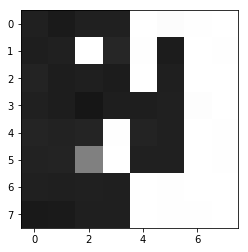

In [79]:
P_Image = get_RGB(p0)[1]
plt.imshow(P_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

### Extracting IBM's watermark

In [81]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas_phi = QuantumCircuit(n, n)
meas_phi.barrier(range(n))
meas_phi.u2(np.pi, np.pi, 0)
# map the quantum measurement to the classical bits
meas_phi.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc_phi = qc_init + meas_phi

#drawing the circuit
#qc_phi.draw('mpl')

In [82]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc_phi, backend_sim, shots=shots0)#, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

In [83]:
counts = result_sim.get_counts(qc_phi)
print(counts)
#from qiskit.visualization import plot_histogram
#plot_histogram(counts)

{'0000000': 10831, '0000001': 4837, '0010000': 5744, '0010001': 10106, '0010010': 5633, '0010011': 9859, '0010100': 7779, '0010101': 7681, '0010110': 5488, '0010111': 10034, '0011000': 7739, '0011001': 7884, '0011010': 5748, '0011011': 9998, '0011100': 7911, '0011101': 7752, '0011110': 7706, '0011111': 7935, '0000010': 10866, '0100000': 10963, '0100001': 4820, '0100010': 10913, '0100011': 4916, '0100100': 10860, '0100101': 4717, '0100110': 10733, '0100111': 4746, '0101000': 7938, '0101001': 7768, '0101010': 10852, '0101011': 4730, '0101100': 7685, '0101101': 7658, '0101110': 7893, '0101111': 7605, '0000011': 4666, '0110000': 5504, '0110001': 9872, '0110010': 10766, '0110011': 4850, '0110100': 5966, '0110101': 9516, '0110110': 5667, '0110111': 10007, '0111000': 10807, '0111001': 4790, '0111010': 5635, '0111011': 10228, '0111100': 7619, '0111101': 7878, '0111110': 7809, '0111111': 7793, '0000100': 10873, '1000000': 5579, '1000001': 9953, '1000010': 10962, '1000011': 4726, '1000100': 5287

In [84]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[1.0831e-02 4.8370e-03 1.0866e-02 4.6660e-03 1.0873e-02 4.7520e-03
 1.0658e-02 4.8270e-03 7.9500e-03 7.7250e-03 8.0730e-03 7.3730e-03
 7.9100e-03 7.5290e-03 7.8570e-03 7.6410e-03 5.7440e-03 1.0106e-02
 5.6330e-03 9.8590e-03 7.7790e-03 7.6810e-03 5.4880e-03 1.0034e-02
 7.7390e-03 7.8840e-03 5.7480e-03 9.9980e-03 7.9110e-03 7.7520e-03
 7.7060e-03 7.9350e-03 1.0963e-02 4.8200e-03 1.0913e-02 4.9160e-03
 1.0860e-02 4.7170e-03 1.0733e-02 4.7460e-03 7.9380e-03 7.7680e-03
 1.0852e-02 4.7300e-03 7.6850e-03 7.6580e-03 7.8930e-03 7.6050e-03
 5.5040e-03 9.8720e-03 1.0766e-02 4.8500e-03 5.9660e-03 9.5160e-03
 5.6670e-03 1.0007e-02 1.0807e-02 4.7900e-03 5.6350e-03 1.0228e-02
 7.6190e-03 7.8780e-03 7.8090e-03 7.7930e-03 5.5790e-03 9.9530e-03
 1.0962e-02 4.7260e-03 5.2870e-03 1.0185e-02 7.7210e-03 7.9190e-03
 1.0918e-02 4.7070e-03 5.6710e-03 1.0086e-02 7.7960e-03 7.7360e-03
 7.7650e-03 7.8700e-03 1.0927e-02 4.8190e-03 1.0933e-02 4.7740e-03
 1.5555e-02 1.0000e-06 8.0620e-03 7.7750e-03 1.0831e-02 4.8020

In [85]:
P0_1 = probability_vector[0::2] 
P1_1= probability_vector[1::2]

In [86]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas_phi2 = QuantumCircuit(n, n)
meas_phi2.barrier(range(n))
meas_phi2.u2(-np.pi/2, np.pi/2, 0)
# map the quantum measurement to the classical bits
meas_phi2.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc_phi2 = qc_init + meas_phi2

#drawing the circuit
#qc_phi2.draw('mpl')

In [88]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc_phi2, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

In [89]:
counts = result_sim.get_counts(qc_phi2)
print(counts)
#from qiskit.visualization import plot_histogram
#plot_histogram(counts)

{'0000000': 7746, '0000001': 7716, '0010000': 9897, '0010001': 5605, '0010010': 9826, '0010011': 5771, '0010100': 7783, '0010101': 7847, '0010110': 9798, '0010111': 5653, '0011000': 7874, '0011001': 7962, '0011010': 9923, '0011011': 5779, '0011100': 7708, '0011101': 7754, '0011110': 8113, '0011111': 7792, '0000010': 7733, '0100000': 7727, '0100001': 8008, '0100010': 7653, '0100011': 7969, '0100100': 7752, '0100101': 7871, '0100110': 7840, '0100111': 7967, '0101000': 7843, '0101001': 7737, '0101010': 7700, '0101011': 7950, '0101100': 7810, '0101101': 7823, '0101110': 7964, '0101111': 7736, '0000011': 7906, '0110000': 9734, '0110001': 5722, '0110010': 7682, '0110011': 7823, '0110100': 9407, '0110101': 6065, '0110110': 9958, '0110111': 5677, '0111000': 7903, '0111001': 7848, '0111010': 9875, '0111011': 5694, '0111100': 7944, '0111101': 7756, '0111110': 7881, '0111111': 7784, '0000100': 7808, '1000000': 9974, '1000001': 5797, '1000010': 7539, '1000011': 7773, '1000100': 9989, '1000101': 52

In [90]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.007746 0.007716 0.007733 0.007906 0.007808 0.007896 0.00784  0.00792
 0.007938 0.007761 0.007753 0.007819 0.007769 0.00789  0.00766  0.007866
 0.009897 0.005605 0.009826 0.005771 0.007783 0.007847 0.009798 0.005653
 0.007874 0.007962 0.009923 0.005779 0.007708 0.007754 0.008113 0.007792
 0.007727 0.008008 0.007653 0.007969 0.007752 0.007871 0.00784  0.007967
 0.007843 0.007737 0.0077   0.00795  0.00781  0.007823 0.007964 0.007736
 0.009734 0.005722 0.007682 0.007823 0.009407 0.006065 0.009958 0.005677
 0.007903 0.007848 0.009875 0.005694 0.007944 0.007756 0.007881 0.007784
 0.009974 0.005797 0.007539 0.007773 0.009989 0.00529  0.007912 0.007555
 0.007751 0.00782  0.009999 0.005665 0.008056 0.007791 0.007852 0.007597
 0.007712 0.007714 0.00769  0.007792 0.007759 0.007929 0.00775  0.007937
 0.007722 0.008045 0.007734 0.007799 0.007822 0.007788 0.007906 0.007903
 0.009912 0.005771 0.00996  0.005726 0.009904 0.00574  0.009926 0.005638
 0.007955 0.007767 0.007736 0.007687 0.007759 0.0078

In [91]:
P0_2 = probability_vector[0::2] 
P1_2 = probability_vector[1::2]

In [92]:
x = P0_1 - P1_1
y = P0_2 - P1_2

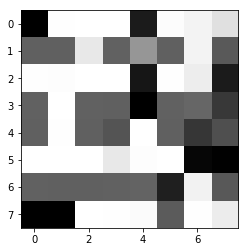

In [93]:
RW_Image = get_watermark(x,y)
plt.imshow(RW_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

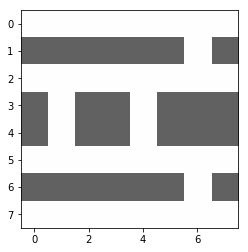

In [94]:
plt.imshow(W_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()